In [178]:
import torch
import shap
from torch import nn
import torch.nn.functional as f
from torchvision import datasets, transforms
from torch import optim

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import helper

In [179]:
#define all arguments and their values
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 128
        self.lr = 0.01
        self.seed = 7   
        self.num_epochs=2

In [180]:
#Define our CNN network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x, 2, 2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = f.relu(self.fc1(x))
        x = f.dropout(x, training=self.training)
        x = self.fc2(x)
        return f.log_softmax(x, dim=1) 

In [181]:
# train data and a test data (without any rotation) set
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,)),
                              ])

args = Arguments()
torch.manual_seed(args.seed)

# MNIST: Download and load the training data
trainset_mnist = datasets.MNIST('MNIST_data/', download = True, train = True, transform = transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size = args.batch_size, shuffle = True)
# MNIST: Download and load the test data
testset_mnist = datasets.MNIST('MNIST_data/', train = False, transform = transform)


testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size = args.test_batch_size, shuffle = True)


# FashionMNIST: Download and load the training data
trainset_fashion = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader_fashion = torch.utils.data.DataLoader(trainset_fashion, batch_size=args.test_batch_size, shuffle=True)

# Download and load the test data
testset_fashion = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader_fashion = torch.utils.data.DataLoader(testset_fashion, batch_size=args.test_batch_size, shuffle=True)

In [182]:
#Create an objective of the defined CNN model
model = Net()
#Set the model in evaluation mode. In this case this is for the Dropout layers
#model.eval()

#Create an objective "for attack" of the defined CNN model
#pmodel = Net()
#Set the model in evaluation mode. In this case this is for the Dropout layers
#pmodel.eval()

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.5)

In [183]:
#To view image and its prediction
def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze() 
    print('Predict class confidence:',ps)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
def predict(img):
    with torch.no_grad():
        logits = model.forward(img)

    ps = f.softmax(logits, dim=1)
    view_classify(img.view(1, 28, 28), ps)

def test_image(img, view = False):
    with torch.no_grad():
        logits = model.forward(img.float())

    ps = f.softmax(logits, dim=1)
    _, label = torch.max(ps, 1)
    if view:
        view_classify(img, ps)
    
    return label    

An images from MNIST and FashionMNIST before training the CNN model
Predict class confidence: [0.10887852 0.09701745 0.09982552 0.11078748 0.0921651  0.11682634
 0.09243121 0.10501523 0.09922107 0.07783213]
Predict class confidence: [0.10534811 0.09582923 0.0960803  0.11076964 0.09433842 0.09117828
 0.09928401 0.10971936 0.09586739 0.10158526]


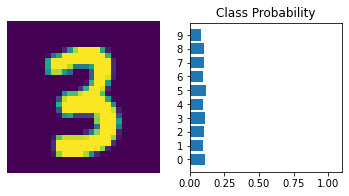

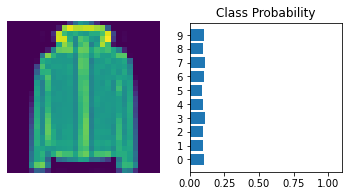

In [184]:
#checked all downloaded train and test data  
print('An images from MNIST and FashionMNIST before training the CNN model')

image_mnist, label_mnist = next(iter(testloader_mnist))
img = image_mnist[0].unsqueeze(0)
predict(img)

image_fashion, label_fashion = next(iter(testloader_fashion))
img = image_fashion[0].unsqueeze(0)
predict(img)

In [185]:
# Now Training and testing of the CNN network model
optimizer = optim.SGD(model.parameters(), lr=args.lr)

    
def training(train_loader, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
 
        optimizer.zero_grad()
        logits = model.forward(data)
        loss = f.nll_loss(logits, target)
        loss.backward()
        optimizer.step() 
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [186]:
for e in range(10):
    running_loss = 0
    count_batch=0
    print('Training for MNIST dataset:')
    training(trainloader_mnist,e)
    print('Training for Fashion_MNIST dataset:')
    training(trainloader_fashion,e)

Training for MNIST dataset:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.286983
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.700990
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.508227
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.611448
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.227956
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.347500
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.379761
Train Epoch: 0 [22400/60000 (37%)]	Loss: 0.208458
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.214923
Train Epoch: 0 [28800/60000 (48%)]	Loss: 0.212152
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.124254
Train Epoch: 0 [35200/60000 (59%)]	Loss: 0.341568
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.330778
Train Epoch: 0 [41600/60000 (69%)]	Loss: 0.055404
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.109505
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.065185
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.171727
Train Epoch: 0 [54400/60000 (91%)]	Loss: 0.447721
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.084604
Training for Fashion_MNIST data

Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.058720
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.017831
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.003757
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.140057
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.015644
Training for Fashion_MNIST dataset:
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.612541
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.414111
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.383554
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.383409
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.439056
Training for MNIST dataset:
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.067163
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.010721
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.072457
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.007734
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.034366
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.001565
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.023359
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.003261
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.015285


An images from MNIST and FashionMNIST after training the CNN model
Predict class confidence: [4.3091066e-03 1.0761557e-06 1.3547734e-04 2.3824339e-06 1.2696307e-06
 1.0066007e-02 2.1115620e-05 7.2425668e-05 9.8533773e-01 5.3453630e-05]
Predict class confidence: [9.4878870e-01 5.0471056e-07 3.1126805e-05 6.6289358e-04 2.0552627e-06
 1.3609264e-06 5.0492849e-02 6.8937744e-09 2.0579135e-05 2.5474998e-09]


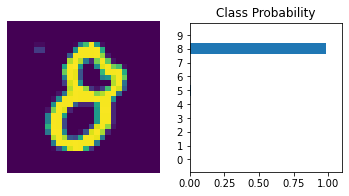

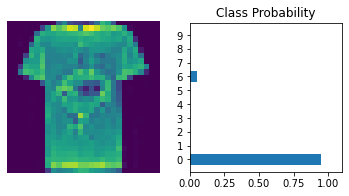

In [187]:
#checked all downloaded train and test data  
print('An images from MNIST and FashionMNIST after training the CNN model')

image_mnist, label_mnist = next(iter(testloader_mnist))
img5 = image_mnist[0].unsqueeze(0)
predict(img5)

image_fashion, label_fashion = next(iter(testloader_fashion))
img = image_fashion[0].unsqueeze(0)
predict(img)

In [236]:
##***** ABC_Algo
import random

def abc_conf_metric(img, label, e):
    score, numerator, denominator, probability = 0, 0, 0, 0

    
    #Line1: Find attribute of each image pixcel   
    shap_values = e.shap_values(img) #computes attribute value for each class (feature 0 to 9)
    
    #Line2: Obtain model prediction
    #print("Original Label", org_label)
    #Line3 to 5:
    #step1: compute denominator of the probability for each class (feature 0 to 9)
    s_img = shap_values[label]

    for p, batch in enumerate(s_img): 
        for q, channel in enumerate(batch):
            for r, row in enumerate(channel):
                for s, col in enumerate(row):
                    pixcel= img[p][q][r][s]
                    #store denominator for each class
                    if pixcel!= 0:
                        denominator += abs(s_img[p][q][r][s] / pixcel) 

    t_img = img.detach().clone()
    changed_attrs, pixcel_count = 0, 0
    for q, channel in enumerate(batch):
        for r, row in enumerate(channel):
            for s, col in enumerate(row):
                pixcel= t_img[p][q][r][s]
                pixcel_count +=1
                if pixcel!= 0:
                    #probability= abs((iset[p][q][r][s]/ t_img[p][q][r][s]))/denominator[d_index]
                    probability= abs((s_img[p][q][r][s]/ pixcel)) / denominator

                if probability > 0.005:
                    changed_attrs = changed_attrs + 1
                    #t_img[p][q][r][s] = random.uniform(-1, 1)
                    t_img[p][q][r][s] = 0 
                    # Test for the mutated images
                    mutated_label = test_image(t_img) 
                    #print(label, mutated_label[0])
                    if label == mutated_label[0]:
                        score += 1 

    print(changed_attrs)
    if changed_attrs !=0:
        score /= changed_attrs
        
    return score, t_img

In [237]:
#Deep explainer for ABC algo
# A random sample of test data of MNIST
batch = next(iter(testloader_mnist))
images, labels = batch
baseline = images
shap_attr = shap.DeepExplainer(model, baseline)

In [190]:
%%time
#test for an image
batch = next(iter(testloader_mnist))
data, target = batch
print (target[0])
print ('---------')
img = data[0].view(1, 1, 28, 28)
print (abc_conf_metric(img5, 5, shap_attr))

tensor(9)
---------
365
0.0547945205479452
CPU times: user 41 s, sys: 2.72 s, total: 43.7 s
Wall time: 878 ms


# FGSM

In [191]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [192]:
def pgd_attack(images, epsilon, alpha, data_grad) :
    sign_data_grad = data_grad.sign()
    ori_images = images.data
    #adv_images = images + alpha *images.grad.sign()
    adv_images = images + alpha *sign_data_grad
    eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
    images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [193]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
alpha=2/255

In [194]:
#test for an image
batch = next(iter(testloader_mnist))
data, target = batch
data.requires_grad = True
img5 = data[0].view(1, 1, 28, 28)
print (target[0])
print ('---------')

tensor(5)
---------


In [195]:
output = model.forward(data)
# Calculate the loss
loss = f.nll_loss(output, target)
# Zero all existing gradients
model.zero_grad()
# Calculate gradients of model in backward pass
loss.backward()
# Collect datagrad
data_grad = data.grad.data


In [196]:
%%time
pgd_img = pgd_attack(img5, 1000, alpha, data_grad)

CPU times: user 58.3 ms, sys: 1.08 ms, total: 59.4 ms
Wall time: 1.24 ms


In [197]:
%%time
fgsm_img = fgsm_attack(img5, epsilons[6], data_grad)

CPU times: user 40.4 ms, sys: 1.44 ms, total: 41.9 ms
Wall time: 1.08 ms


In [198]:
def predict(model, img, view = True):
    with torch.no_grad():
        logits = model.forward(img)

    ps = f.softmax(logits, dim=1)
    if view:
        view_classify(img.view(1, 28, 28), ps)
    
    _, label = torch.max(ps, 1)
    return label

In [199]:
for img in pgd_img:
    lbl = predict(model, img.unsqueeze(0), False)
    if lbl != 5:
        print(lbl)
    

In [200]:
for img in fgsm_img:
    lbl = predict(model, img.unsqueeze(0), False)
    if lbl != 5:
        print(lbl)
    

<AxesSubplot:>

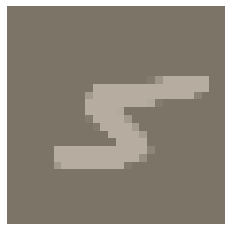

In [209]:
helper.imshow(pgd_img[100].detach())

In [238]:
score, timg = abc_conf_metric(img5, 5, shap_attr)

47


In [239]:
print(timg.shape)

torch.Size([1, 1, 28, 28])


<AxesSubplot:>

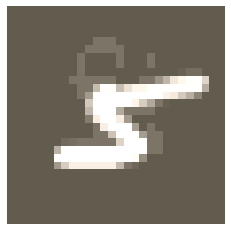

In [240]:
helper.imshow(timg.squeeze(0))